## Predicting Respiratory Rate
#### Team Name: The Pandas

Part of the AI for Healthcare Hackathon 2019

Andrew Armstrong, Irina Nedelcu, Eugene Olkhov

In [5]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import math
import pycwt as wavelet
import numpy as np

In [6]:
# set up the working directory
path = r'.' # use your path

#Link to download data: https://www.dropbox.com/s/5j0r1c8phl4891e/bidmc_csv_zip.zip?dl=0

#Original data had to be scraped in order to make it easier to batch download all of the individual csv files. 
#Click direct download in the link above, and then set your path as shown in the 2nd line. 

# create an empty list that will contain the files
li = []

# read files and add them too the list 'li'
for n in range(1,53):
    s = str(n)
    if len(s) == 1:
        s = "0" + s
    else:
        s = s
    pb = path + "/bidmc_" + s + "_Breaths.csv"
    ps = path + "/bidmc_" + s + "_Signals.csv"
    df1 = pd.read_csv(pb, index_col=None, header=0)
    df2 = pd.read_csv(ps, index_col=None, header=0)
    df2['breaths'] = 0
    # if there is a breath at a certain point in time, then put 1, otherwise 0
    for i in range(df1.shape[0]):
        o = df1.iloc[i,0]
        if math.isnan(o) == False:
            c = df2.shape[1]-1
            df2.iloc[int(o),c] = 1
        
    df2['id'] = n
    li.append(df2)

In [37]:
# display summary statistics of the first file
li[0].describe()

,Time [s],RESP,PLETH,V,AVR,II,breaths,id
count,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.0
mean,240.000000,0.463901,0.465795,0.479294,0.477605,0.464972,0.002833,1.0
std,138.567529,0.320779,0.065513,0.166586,0.160749,0.232832,0.053154,0.0
min,0.000000,0.000000,0.223850,-0.501960,-0.498040,-0.501960,0.000000,1.0
25%,120.000000,0.187680,0.410560,0.490200,0.470590,0.345100,0.000000,1.0
50%,240.000000,0.347020,0.446730,0.509800,0.539220,0.374510,0.000000,1.0
75%,360.000000,0.760510,0.509290,0.525490,0.554900,0.480390,0.000000,1.0
max,480.000000,1.000000,0.697950,1.503900,1.047100,1.503900,1.000000,1.0


In [7]:
# create the wavelet function
def calculateCWT(t,s,steps):
    mother = wavelet.Morlet(7)
    deltaT = t[1] - t[0]
    dj = 1 / steps        
    s0 = 2 * deltaT      
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(s, deltaT, dj, s0, -1, mother)
    power = (np.abs(wave)) ** 2
    return power,scales,coi,freqs

def cwt_output(power,scale):
    id=next(i for i, v in enumerate(scale) if v>60)
    xp=power[:id,:]
    maxidx=np.argmax(xp,axis=0)
    return scale[maxidx]

#Credit for function: https://github.com/danielefranceschi/wavelets-climatological-time-series

In [8]:
# for each dataset, apply wavelet function to remove noise from the PLETH column
# the new column will be used as independent variable to predict 'Resp' colum from 'Signals' data
for i in range(0, 52):
    power,scales,coi,freqs=calculateCWT(range(0,len(li[i])),li[i][' PLETH'],50)
    wcl=cwt_output(power,scales)
    li[i]['WavePLETH'] = wcl

# show the head of the first dataset; last column was computed above
li[0].head()

,Time [s],RESP,PLETH,V,AVR,II,breaths,id,WavePLETH
0,0.000,0.35386,0.43597,0.52549,0.30392,0.72549,0,1,44.017338
1,0.008,0.35679,0.43206,0.51961,0.33529,0.67059,0,1,43.411338
2,0.016,0.35875,0.42815,0.51569,0.37451,0.60980,0,1,43.411338
3,0.024,0.36168,0.42424,0.50588,0.41961,0.55098,0,1,43.411338
4,0.032,0.36364,0.42131,0.50980,0.44902,0.50000,0,1,43.411338


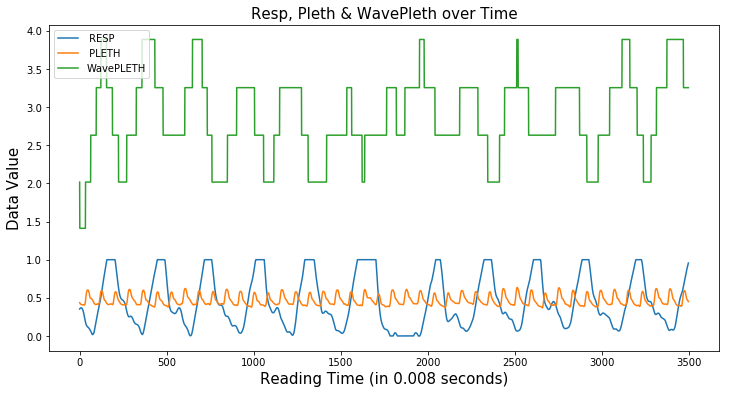

In [44]:
# for the first patient, display 'Resp' vs 'Pleth' vs 'WavePleth' (new column)
line_fig = plt.figure(figsize = (12, 6))
_ = plt.plot(li[0][0:3500][' RESP'])
_ = plt.plot(li[0][0:3500][' PLETH'])
_ = plt.plot(li[0][0:3500]['WavePLETH'] - 42) # substracting 42 to show the graphs closer to each other
_ = plt.legend(loc=2)
_ = plt.xlabel("Reading Time (in 0.008 seconds)", fontsize = 15)
_ = plt.ylabel("Data Value", fontsize = 15)
_ = plt.title("Resp, Pleth & WavePleth over Time", fontsize = 15)
plt.show()

##### The Pleth variable doesn't show any clear trend that would help predict Resp. After decomposing the Pleth variable, the WavePleth variable seems to have a similar pattern to the Resp variable.
##### Therefore, WavePleth will be used in LSTM model to predict RESP.

## LSTM (Long Short-Term Memory) Modeling

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input

from sklearn.preprocessing import MinMaxScaler

In [10]:
#Restrict patients to retain no more than 60,000 records. This will ensure everyone will have the same amount of records.

list_full = []

for i in range(52):
    df = li[i].loc[0:59999,:]
    list_full.append(df)

In [12]:
#Shape the data into the proper input/output for LSTM. The predictor is WavePLETH, and the target is RESP.

scaler = MinMaxScaler()

#Training    

#X_Input

X_input_list = []
        
for i in range(52):
    df = pd.DataFrame(columns=['WavePLETH'])
    df['WavePLETH'] = list_full[i]['WavePLETH']
    df['WavePLETH'] = scaler.fit_transform(np.array(df['WavePLETH']).reshape(60000,1))
    X_input_array = np.asarray(df).reshape((60000,1,1))
    X_input_list.append(X_input_array)


#Y_Input

Y_input_list = []

for i in range(52):
    df = pd.DataFrame(columns=['RESP'])
    df['RESP'] = list_full[i][' RESP']
    df['RESP'] = scaler.fit_transform(np.array(df['RESP']).reshape(60000,1))
    Y_input_array = np.asarray(df).reshape((60000,1))
    Y_input_list.append(Y_input_array)

In [13]:
#Model building

model5 = Sequential()

model5.add(LSTM(500, batch_input_shape = (None,1,1), return_sequences = True))

model5.add(LSTM(1, activation = 'relu', return_sequences = False))

#Compile model

model5.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

model5.summary() 

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 500)            1004000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 1)                 2008      
Total params: 1,006,008
Trainable params: 1,006,008
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Fitting the model with the training data (first 40 patients). 

for i in range(40):
    print("Fitting to", i)
    history = model5.fit(X_input_list[i], Y_input_list[i], epochs = 5, batch_size = 6000)

Fitting to 0
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - ETA: 17s - loss: 0.3211 - acc: 0.00 - ETA: 8s - loss: 0.3153 - acc: 0.0027 - ETA: 5s - loss: 0.3127 - acc: 0.002 - ETA: 4s - loss: 0.3096 - acc: 0.002 - ETA: 2s - loss: 0.3087 - acc: 0.002 - ETA: 2s - loss: 0.3082 - acc: 0.002 - ETA: 1s - loss: 0.3064 - acc: 0.002 - ETA: 0s - loss: 0.3048 - acc: 0.002 - ETA: 0s - loss: 0.3024 - acc: 0.002 - 4s 70us/step - loss: 0.3008 - acc: 0.0026
Epoch 2/5
60000/60000 [==============================] - ETA: 2s - loss: 0.2819 - acc: 0.001 - ETA: 1s - loss: 0.2807 - acc: 0.001 - ETA: 1s - loss: 0.2792 - acc: 0.002 - ETA: 1s - loss: 0.2765 - acc: 0.002 - ETA: 1s - loss: 0.2746 - acc: 0.002 - ETA: 1s - loss: 0.2729 - acc: 0.002 - ETA: 0s - loss: 0.2716 - acc: 0.002 - ETA: 0s - loss: 0.2699 - acc: 0.002 - ETA: 0s - loss: 0.2677 - acc: 0.002 - 3s 42us/step - loss: 0.2651 - acc: 0.0027
Epoch 3/5
60000/60000 [==============================] -

60000/60000 [==============================] - ETA: 2s - loss: 0.0302 - acc: 1.6667e-0 - ETA: 2s - loss: 0.0296 - acc: 2.5000e-0 - ETA: 1s - loss: 0.0301 - acc: 1.6667e-0 - ETA: 1s - loss: 0.0296 - acc: 1.2500e-0 - ETA: 1s - loss: 0.0295 - acc: 1.0000e-0 - ETA: 1s - loss: 0.0294 - acc: 8.3333e-0 - ETA: 0s - loss: 0.0296 - acc: 9.5238e-0 - ETA: 0s - loss: 0.0296 - acc: 8.3333e-0 - ETA: 0s - loss: 0.0295 - acc: 9.2593e-0 - 3s 46us/step - loss: 0.0295 - acc: 8.3333e-05
Epoch 4/5
60000/60000 [==============================] - ETA: 2s - loss: 0.0286 - acc: 1.6667e-0 - ETA: 2s - loss: 0.0287 - acc: 8.3333e-0 - ETA: 1s - loss: 0.0288 - acc: 1.1111e-0 - ETA: 1s - loss: 0.0288 - acc: 8.3333e-0 - ETA: 1s - loss: 0.0290 - acc: 6.6667e-0 - ETA: 1s - loss: 0.0291 - acc: 5.5556e-0 - ETA: 0s - loss: 0.0293 - acc: 7.1429e-0 - ETA: 0s - loss: 0.0293 - acc: 6.2500e-0 - ETA: 0s - loss: 0.0294 - acc: 5.5556e-0 - 3s 46us/step - loss: 0.0294 - acc: 8.3333e-05
Epoch 5/5
60000/60000 [=========================

60000/60000 [==============================] - ETA: 2s - loss: 0.0658 - acc: 0.0000e+0 - ETA: 2s - loss: 0.0656 - acc: 8.3333e-0 - ETA: 2s - loss: 0.0654 - acc: 1.1111e-0 - ETA: 1s - loss: 0.0651 - acc: 1.2500e-0 - ETA: 1s - loss: 0.0648 - acc: 1.0000e-0 - ETA: 1s - loss: 0.0643 - acc: 8.3333e-0 - ETA: 0s - loss: 0.0639 - acc: 9.5238e-0 - ETA: 0s - loss: 0.0634 - acc: 8.3333e-0 - ETA: 0s - loss: 0.0629 - acc: 7.4074e-0 - 3s 49us/step - loss: 0.0625 - acc: 6.6667e-05
Epoch 2/5
60000/60000 [==============================] - ETA: 2s - loss: 0.0582 - acc: 1.6667e-0 - ETA: 2s - loss: 0.0584 - acc: 8.3333e-0 - ETA: 2s - loss: 0.0576 - acc: 5.5556e-0 - ETA: 1s - loss: 0.0571 - acc: 1.2500e-0 - ETA: 1s - loss: 0.0567 - acc: 1.0000e-0 - ETA: 1s - loss: 0.0567 - acc: 8.3333e-0 - ETA: 0s - loss: 0.0563 - acc: 7.1429e-0 - ETA: 0s - loss: 0.0562 - acc: 6.2500e-0 - ETA: 0s - loss: 0.0560 - acc: 7.4074e-0 - 3s 51us/step - loss: 0.0560 - acc: 6.6667e-05
Epoch 3/5
60000/60000 [=========================

60000/60000 [==============================] - ETA: 2s - loss: 0.0175 - acc: 0.0000e+0 - ETA: 2s - loss: 0.0173 - acc: 8.3333e-0 - ETA: 2s - loss: 0.0174 - acc: 5.5556e-0 - ETA: 1s - loss: 0.0172 - acc: 8.3333e-0 - ETA: 1s - loss: 0.0174 - acc: 1.0000e-0 - ETA: 1s - loss: 0.0174 - acc: 8.3333e-0 - ETA: 0s - loss: 0.0173 - acc: 7.1429e-0 - ETA: 0s - loss: 0.0173 - acc: 6.2500e-0 - ETA: 0s - loss: 0.0172 - acc: 5.5556e-0 - 3s 54us/step - loss: 0.0172 - acc: 6.6667e-05
Epoch 4/5
60000/60000 [==============================] - ETA: 2s - loss: 0.0166 - acc: 0.0000e+0 - ETA: 2s - loss: 0.0169 - acc: 8.3333e-0 - ETA: 2s - loss: 0.0166 - acc: 5.5556e-0 - ETA: 1s - loss: 0.0167 - acc: 1.2500e-0 - ETA: 1s - loss: 0.0168 - acc: 1.0000e-0 - ETA: 1s - loss: 0.0169 - acc: 8.3333e-0 - ETA: 0s - loss: 0.0170 - acc: 7.1429e-0 - ETA: 0s - loss: 0.0172 - acc: 6.2500e-0 - ETA: 0s - loss: 0.0172 - acc: 5.5556e-0 - 3s 54us/step - loss: 0.0172 - acc: 6.6667e-05
Epoch 5/5
60000/60000 [=========================

60000/60000 [==============================] - ETA: 2s - loss: 0.0176 - acc: 0.001 - ETA: 2s - loss: 0.0174 - acc: 0.001 - ETA: 2s - loss: 0.0173 - acc: 0.001 - ETA: 1s - loss: 0.0173 - acc: 0.001 - ETA: 1s - loss: 0.0172 - acc: 0.001 - ETA: 1s - loss: 0.0171 - acc: 0.001 - ETA: 0s - loss: 0.0171 - acc: 0.001 - ETA: 0s - loss: 0.0171 - acc: 0.001 - ETA: 0s - loss: 0.0171 - acc: 0.001 - 3s 50us/step - loss: 0.0171 - acc: 0.0019
Fitting to 14
Epoch 1/5
60000/60000 [==============================] - ETA: 2s - loss: 0.0429 - acc: 0.012 - ETA: 2s - loss: 0.0417 - acc: 0.012 - ETA: 2s - loss: 0.0418 - acc: 0.013 - ETA: 1s - loss: 0.0420 - acc: 0.013 - ETA: 1s - loss: 0.0419 - acc: 0.013 - ETA: 1s - loss: 0.0419 - acc: 0.013 - ETA: 0s - loss: 0.0420 - acc: 0.013 - ETA: 0s - loss: 0.0420 - acc: 0.013 - ETA: 0s - loss: 0.0420 - acc: 0.013 - 3s 49us/step - loss: 0.0420 - acc: 0.0138
Epoch 2/5
60000/60000 [==============================] - ETA: 2s - loss: 0.0417 - acc: 0.013 - ETA: 2s - loss: 0.0

60000/60000 [==============================] - ETA: 2s - loss: 0.0644 - acc: 0.0000e+0 - ETA: 2s - loss: 0.0639 - acc: 0.0000e+0 - ETA: 2s - loss: 0.0638 - acc: 0.0000e+0 - ETA: 1s - loss: 0.0634 - acc: 0.0000e+0 - ETA: 1s - loss: 0.0635 - acc: 3.3333e-0 - ETA: 1s - loss: 0.0636 - acc: 5.5556e-0 - ETA: 0s - loss: 0.0633 - acc: 7.1429e-0 - ETA: 0s - loss: 0.0633 - acc: 6.2500e-0 - ETA: 0s - loss: 0.0632 - acc: 7.4074e-0 - 3s 52us/step - loss: 0.0633 - acc: 6.6667e-05
Epoch 4/5
60000/60000 [==============================] - ETA: 2s - loss: 0.0630 - acc: 0.0000e+0 - ETA: 2s - loss: 0.0632 - acc: 0.0000e+0 - ETA: 2s - loss: 0.0634 - acc: 0.0000e+0 - ETA: 1s - loss: 0.0631 - acc: 0.0000e+0 - ETA: 1s - loss: 0.0631 - acc: 0.0000e+0 - ETA: 1s - loss: 0.0628 - acc: 0.0000e+0 - ETA: 0s - loss: 0.0629 - acc: 2.3810e-0 - ETA: 0s - loss: 0.0631 - acc: 8.3333e-0 - ETA: 0s - loss: 0.0631 - acc: 7.4074e-0 - 3s 53us/step - loss: 0.0631 - acc: 6.6667e-05
Epoch 5/5
60000/60000 [=========================

60000/60000 [==============================] - ETA: 2s - loss: 0.1105 - acc: 0.040 - ETA: 2s - loss: 0.1111 - acc: 0.041 - ETA: 2s - loss: 0.1116 - acc: 0.041 - ETA: 1s - loss: 0.1121 - acc: 0.041 - ETA: 1s - loss: 0.1126 - acc: 0.042 - ETA: 1s - loss: 0.1127 - acc: 0.041 - ETA: 0s - loss: 0.1127 - acc: 0.041 - ETA: 0s - loss: 0.1128 - acc: 0.041 - ETA: 0s - loss: 0.1127 - acc: 0.042 - 3s 50us/step - loss: 0.1125 - acc: 0.0426
Fitting to 21
Epoch 1/5
60000/60000 [==============================] - ETA: 2s - loss: 0.1421 - acc: 0.029 - ETA: 2s - loss: 0.1409 - acc: 0.028 - ETA: 2s - loss: 0.1415 - acc: 0.029 - ETA: 1s - loss: 0.1417 - acc: 0.029 - ETA: 1s - loss: 0.1410 - acc: 0.029 - ETA: 1s - loss: 0.1412 - acc: 0.028 - ETA: 0s - loss: 0.1410 - acc: 0.028 - ETA: 0s - loss: 0.1408 - acc: 0.028 - ETA: 0s - loss: 0.1407 - acc: 0.028 - 3s 49us/step - loss: 0.1408 - acc: 0.0288
Epoch 2/5
60000/60000 [==============================] - ETA: 2s - loss: 0.1387 - acc: 0.029 - ETA: 2s - loss: 0.1

60000/60000 [==============================] - ETA: 2s - loss: 0.0514 - acc: 0.001 - ETA: 2s - loss: 0.0517 - acc: 8.3333e-0 - ETA: 2s - loss: 0.0523 - acc: 7.2222e-0 - ETA: 1s - loss: 0.0527 - acc: 5.4167e-0 - ETA: 1s - loss: 0.0528 - acc: 4.6667e-0 - ETA: 1s - loss: 0.0527 - acc: 5.0000e-0 - ETA: 0s - loss: 0.0529 - acc: 4.5238e-0 - ETA: 0s - loss: 0.0529 - acc: 5.0000e-0 - ETA: 0s - loss: 0.0529 - acc: 5.0000e-0 - 3s 51us/step - loss: 0.0528 - acc: 4.8333e-04
Epoch 3/5
60000/60000 [==============================] - ETA: 2s - loss: 0.0513 - acc: 8.3333e-0 - ETA: 2s - loss: 0.0521 - acc: 5.8333e-0 - ETA: 2s - loss: 0.0521 - acc: 5.0000e-0 - ETA: 1s - loss: 0.0521 - acc: 4.5833e-0 - ETA: 1s - loss: 0.0521 - acc: 4.6667e-0 - ETA: 1s - loss: 0.0523 - acc: 4.7222e-0 - ETA: 0s - loss: 0.0526 - acc: 4.2857e-0 - ETA: 0s - loss: 0.0526 - acc: 4.3750e-0 - ETA: 0s - loss: 0.0526 - acc: 5.1852e-0 - 3s 51us/step - loss: 0.0526 - acc: 4.8333e-04
Epoch 4/5
60000/60000 [=============================

60000/60000 [==============================] - ETA: 2s - loss: 0.1975 - acc: 0.350 - ETA: 2s - loss: 0.1965 - acc: 0.354 - ETA: 2s - loss: 0.1956 - acc: 0.355 - ETA: 1s - loss: 0.1953 - acc: 0.352 - ETA: 1s - loss: 0.1953 - acc: 0.353 - ETA: 1s - loss: 0.1946 - acc: 0.353 - ETA: 0s - loss: 0.1947 - acc: 0.355 - ETA: 0s - loss: 0.1947 - acc: 0.356 - ETA: 0s - loss: 0.1949 - acc: 0.358 - 3s 54us/step - loss: 0.1951 - acc: 0.3596
Fitting to 28
Epoch 1/5
60000/60000 [==============================] - ETA: 2s - loss: 0.0331 - acc: 0.002 - ETA: 2s - loss: 0.0325 - acc: 0.002 - ETA: 2s - loss: 0.0320 - acc: 0.002 - ETA: 1s - loss: 0.0313 - acc: 0.002 - ETA: 1s - loss: 0.0305 - acc: 0.003 - ETA: 1s - loss: 0.0296 - acc: 0.003 - ETA: 0s - loss: 0.0286 - acc: 0.003 - ETA: 0s - loss: 0.0277 - acc: 0.003 - ETA: 0s - loss: 0.0269 - acc: 0.003 - 3s 54us/step - loss: 0.0261 - acc: 0.0032
Epoch 2/5
60000/60000 [==============================] - ETA: 2s - loss: 0.0185 - acc: 0.002 - ETA: 2s - loss: 0.0

60000/60000 [==============================] - ETA: 2s - loss: 0.0800 - acc: 0.0000e+0 - ETA: 2s - loss: 0.0798 - acc: 0.0000e+0 - ETA: 2s - loss: 0.0800 - acc: 5.5556e-0 - ETA: 1s - loss: 0.0804 - acc: 4.1667e-0 - ETA: 1s - loss: 0.0803 - acc: 6.6667e-0 - ETA: 1s - loss: 0.0801 - acc: 5.5556e-0 - ETA: 0s - loss: 0.0802 - acc: 4.7619e-0 - ETA: 0s - loss: 0.0800 - acc: 4.1667e-0 - ETA: 0s - loss: 0.0801 - acc: 3.7037e-0 - 3s 50us/step - loss: 0.0799 - acc: 3.3333e-05
Epoch 4/5
60000/60000 [==============================] - ETA: 2s - loss: 0.0788 - acc: 0.0000e+0 - ETA: 2s - loss: 0.0785 - acc: 0.0000e+0 - ETA: 2s - loss: 0.0797 - acc: 0.0000e+0 - ETA: 1s - loss: 0.0799 - acc: 4.1667e-0 - ETA: 1s - loss: 0.0795 - acc: 3.3333e-0 - ETA: 1s - loss: 0.0797 - acc: 5.5556e-0 - ETA: 0s - loss: 0.0798 - acc: 4.7619e-0 - ETA: 0s - loss: 0.0796 - acc: 4.1667e-0 - ETA: 0s - loss: 0.0798 - acc: 3.7037e-0 - 3s 51us/step - loss: 0.0798 - acc: 3.3333e-05
Epoch 5/5
60000/60000 [=========================

60000/60000 [==============================] - ETA: 2s - loss: 0.2242 - acc: 0.535 - ETA: 2s - loss: 0.2235 - acc: 0.537 - ETA: 2s - loss: 0.2242 - acc: 0.533 - ETA: 1s - loss: 0.2241 - acc: 0.533 - ETA: 1s - loss: 0.2239 - acc: 0.533 - ETA: 1s - loss: 0.2240 - acc: 0.531 - ETA: 0s - loss: 0.2237 - acc: 0.532 - ETA: 0s - loss: 0.2234 - acc: 0.533 - ETA: 0s - loss: 0.2235 - acc: 0.533 - 3s 50us/step - loss: 0.2234 - acc: 0.5333
Fitting to 35
Epoch 1/5
60000/60000 [==============================] - ETA: 2s - loss: 0.0426 - acc: 1.6667e-0 - ETA: 2s - loss: 0.0424 - acc: 8.3333e-0 - ETA: 2s - loss: 0.0420 - acc: 5.5556e-0 - ETA: 1s - loss: 0.0409 - acc: 4.1667e-0 - ETA: 1s - loss: 0.0399 - acc: 6.6667e-0 - ETA: 1s - loss: 0.0389 - acc: 8.3333e-0 - ETA: 0s - loss: 0.0378 - acc: 9.5238e-0 - ETA: 0s - loss: 0.0368 - acc: 8.3333e-0 - ETA: 0s - loss: 0.0359 - acc: 7.4074e-0 - 3s 51us/step - loss: 0.0352 - acc: 8.3333e-05
Epoch 2/5
60000/60000 [==============================] - ETA: 2s - loss: 0

Epoch 3/5
60000/60000 [==============================] - ETA: 2s - loss: 0.2145 - acc: 0.510 - ETA: 2s - loss: 0.2145 - acc: 0.510 - ETA: 2s - loss: 0.2148 - acc: 0.513 - ETA: 1s - loss: 0.2148 - acc: 0.511 - ETA: 1s - loss: 0.2149 - acc: 0.512 - ETA: 1s - loss: 0.2152 - acc: 0.510 - ETA: 0s - loss: 0.2154 - acc: 0.511 - ETA: 0s - loss: 0.2155 - acc: 0.512 - ETA: 0s - loss: 0.2153 - acc: 0.513 - 3s 49us/step - loss: 0.2154 - acc: 0.5127
Epoch 4/5
60000/60000 [==============================] - ETA: 2s - loss: 0.2158 - acc: 0.503 - ETA: 2s - loss: 0.2155 - acc: 0.508 - ETA: 2s - loss: 0.2159 - acc: 0.505 - ETA: 1s - loss: 0.2156 - acc: 0.508 - ETA: 1s - loss: 0.2157 - acc: 0.510 - ETA: 1s - loss: 0.2148 - acc: 0.511 - ETA: 0s - loss: 0.2150 - acc: 0.512 - ETA: 0s - loss: 0.2151 - acc: 0.512 - ETA: 0s - loss: 0.2153 - acc: 0.512 - 3s 50us/step - loss: 0.2154 - acc: 0.5121
Epoch 5/5
60000/60000 [==============================] - ETA: 2s - loss: 0.2170 - acc: 0.500 - ETA: 2s - loss: 0.2165 

The above model was trained on the data for the first 40 patients. We then use the trained model to predict the RESP time series for unseen data. Here is an example of the trained model predicting patient 42, (top), compared to the actual RESP of patient 42 (bottom). The important thing to note is that we care only about the peaks, since this indicates breathing and can be used to get the respiratory rate. As seen below, the model does do a good job in this case of matching the peaks in the correct time span. (Subset was used because all 60,000 is difficult to interpret all at once). 

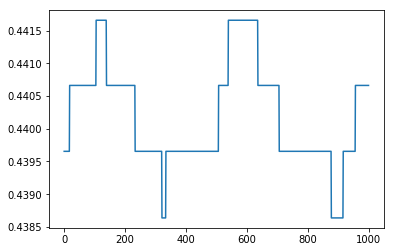

In [29]:
#Predicting for out-of-sample patients

preds42 = model5.predict(X_input_list[43])

plt.plot(preds42[5000:6000])

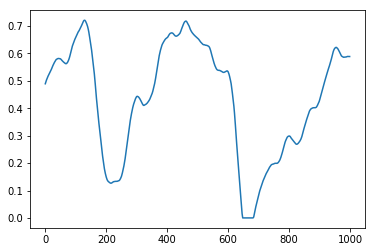

In [30]:
plt.plot(Y_input_list[43][5000:6000])

Below is another example from a different out-of-sample patient.

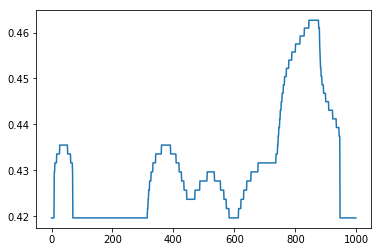

In [22]:
preds43 = model5.predict(X_input_list[44])

plt.plot(preds43[2000:3000])

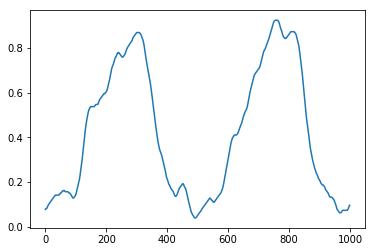

In [23]:
plt.plot(Y_input_list[44][2000:3000])

### Final thoughts:

This analysis showed great potential in being able to identify respiratory rates based on more available and cheaper methods. While our model did not show the best accuracy, we view this as an excellent proof of concept, and show that a fairly shallow LSTM model is able to detect similar peaks on unseen data. We would like to see this work further improved in the future with more complicated modeling. As this project was done within a 24 hour period, we believe that this is a great starting point.